In [131]:
import os
import random
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def set_seed(seed: int = 111):
    random.seed(seed)
    np.random.seed(seed)


set_seed(111)

In [132]:
from datasets import load_dataset
df = load_dataset("mstz/abalone")["train"].to_pandas()

In [133]:
df

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,number_of_rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


array([[<Axes: title={'center': 'length'}>,
        <Axes: title={'center': 'diameter'}>,
        <Axes: title={'center': 'height'}>],
       [<Axes: title={'center': 'whole_weight'}>,
        <Axes: title={'center': 'shucked_weight'}>,
        <Axes: title={'center': 'viscera_weight'}>],
       [<Axes: title={'center': 'shell_weight'}>,
        <Axes: title={'center': 'number_of_rings'}>, <Axes: >]],
      dtype=object)

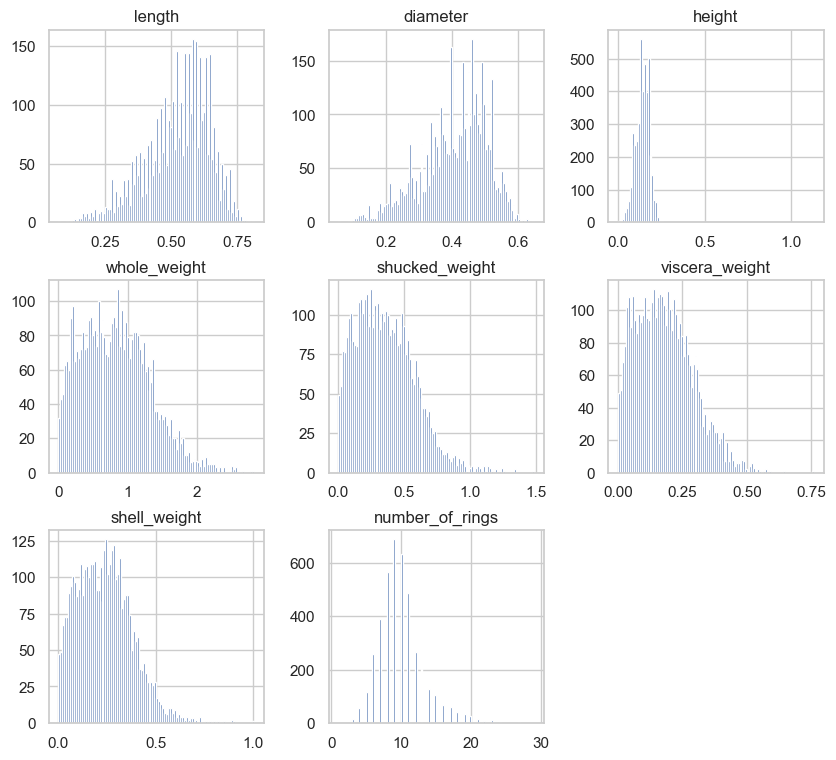

In [134]:
df.hist(figsize=(10, 9), bins=100)

Видим аналогичную проблему, сильный перевес значений целевой переменной в области 10, что скорее всего приведет к тому, что модель будет плохо предсказывать значения далеко от центра распределения (вне 7-13)

In [135]:
from sklearn.model_selection import train_test_split

n_before = len(df)
n_duplicates = df.duplicated().sum()

print(f"Размер до удаления дубликатов: {df.shape}")
print(f"Число полностью дублирующихся строк: {n_duplicates}")

df = df.drop_duplicates().reset_index(drop=True)

df = df.groupby('number_of_rings').head(200).reset_index(drop=True) # Тут это очень помогло, без этого было очень плохо

n_after = len(df)
print(f"Размер после удаления дубликатов: {df.shape}")
print(f"Фактически удалено строк: {n_before - n_after}")

target_col = "number_of_rings"

drop_cols = [target_col]
feature_cols = [c for c in df.columns if c not in drop_cols]

def split_data(features):
    X = df[features]
    y = df[target_col].apply(lambda x: x - 1)

    print("\nЧисло признаков:", X.shape[1])
    print("Список признаков:", features)

    # 20% в тест
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, random_state=111
    )

    # Из оставшихся 80% -> 60% train, 20% val
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=111
    )  # 0.25 * 0.8 = 0.2

    print("\nTrain:", X_train.shape, y_train.shape)
    print("Val:  ", X_val.shape,   y_val.shape)
    print("Test: ", X_test.shape,  y_test.shape)

    return X_test, y_test, X_train, y_train, X_val, y_val

Размер до удаления дубликатов: (4177, 9)
Число полностью дублирующихся строк: 0
Размер после удаления дубликатов: (2279, 9)
Фактически удалено строк: 1898


<Axes: >

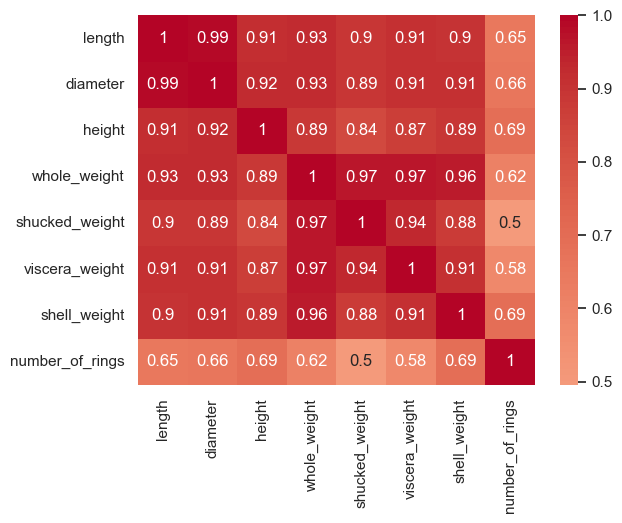

In [136]:
import seaborn as sns

sns.heatmap(df[filter(lambda x: x != 'sex', feature_cols + [target_col])].corr(), annot=True, cmap='coolwarm', center=0)

Видим много коррелирующих меджу собой фичей, что может сильно запутать модель. Однако так как все фичи коррелируют со всеми, то не представляется возможным снизить их количество. При этом с целевой переменной кореляция не такая сильная

In [137]:
def show_corr(correlation, colors='blue'):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(correlation.keys(), correlation.values(), color=colors)

    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')  
        label.set_va('top')    
        label.set_fontsize(8)
        

    plt.xlabel('Признаки')
    plt.ylabel('Корреляция')
    plt.title(f'Корреляция признаков с {target_col}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

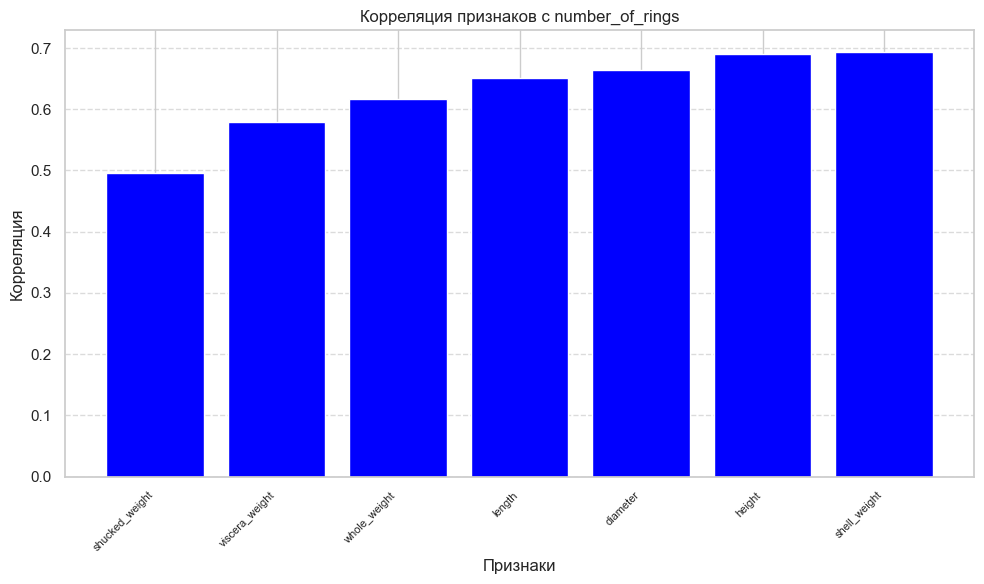

In [138]:
correlation = df[filter(lambda x: x != 'sex', feature_cols)].corrwith(df[[target_col]].iloc[:, 0]).sort_values(key=abs).dropna().to_dict()

show_corr(correlation)

In [139]:
X_test, y_test, X_train, y_train, X_val, y_val = split_data(feature_cols)


Число признаков: 8
Список признаков: ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight']

Train: (1367, 8) (1367,)
Val:   (456, 8) (456,)
Test:  (456, 8) (456,)


In [140]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


results = {}

def log_results(model_name: str, split: str, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    if model_name not in results:
        results[model_name] = {}

    results[model_name][split] = {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
    }

def print_metrics(split_name: str, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"=== {split_name} ===")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"R2  : {r2:.4f}")
    print()

In [141]:
baseline_name = "Baseline: mean"

# средняя аренда только по train
y_train_mean = y_train.mean()
print(f"Среднее качество на train: {y_train_mean:.2f}")

# предсказания: одно и то же число для всех объектов
y_train_pred = np.full_like(y_train, fill_value=y_train_mean, dtype=float)
y_val_pred   = np.full_like(y_val,   fill_value=y_train_mean, dtype=float)
y_test_pred  = np.full_like(y_test,  fill_value=y_train_mean, dtype=float)

# логируем результаты
log_results(baseline_name, "train", y_train, y_train_pred)
log_results(baseline_name, "val",   y_val,   y_val_pred)
log_results(baseline_name, "test",  y_test,  y_test_pred)

# печатаем метрики
print("Модель:", baseline_name)
print_metrics("Train", y_train, y_train_pred)
print_metrics("Val",   y_val,   y_val_pred)
print_metrics("Test",  y_test,  y_test_pred)

Среднее качество на train: 9.58
Модель: Baseline: mean
=== Train ===
MSE : 16.03
RMSE: 4.00
MAE : 3.25
R2  : 0.0000

=== Val ===
MSE : 17.11
RMSE: 4.14
MAE : 3.28
R2  : -0.0001

=== Test ===
MSE : 16.98
RMSE: 4.12
MAE : 3.33
R2  : -0.0002



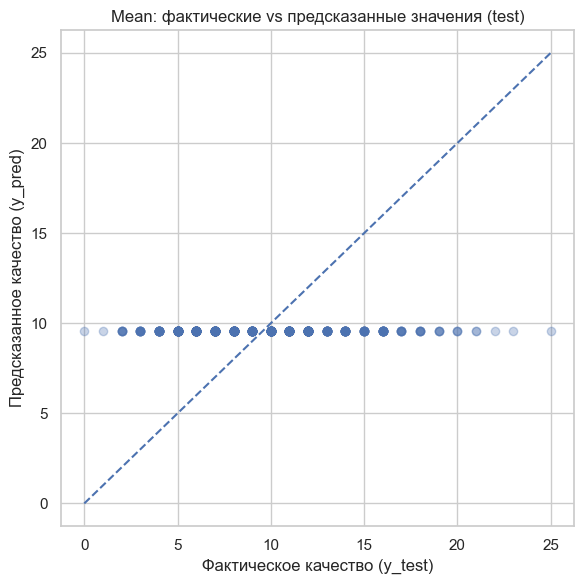

In [142]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Фактическое качество (y_test)")
plt.ylabel("Предсказанное качество (y_pred)")
plt.title(f"Mean: фактические vs предсказанные значения (test)")
plt.tight_layout()
plt.show()

In [143]:
baseline_name = "Baseline: median"

# средняя аренда только по train
y_train_median = y_train.median()
print(f"Среднее качество на train: {y_train_median:.2f}")

# предсказания: одно и то же число для всех объектов
y_train_pred = np.full_like(y_train, fill_value=y_train_median, dtype=float)
y_val_pred   = np.full_like(y_val,   fill_value=y_train_median, dtype=float)
y_test_pred  = np.full_like(y_test,  fill_value=y_train_median, dtype=float)

# логируем результаты
log_results(baseline_name, "train", y_train, y_train_pred)
log_results(baseline_name, "val",   y_val,   y_val_pred)
log_results(baseline_name, "test",  y_test,  y_test_pred)

# печатаем метрики
print("Модель:", baseline_name)
print_metrics("Train", y_train, y_train_pred)
print_metrics("Val",   y_val,   y_val_pred)
print_metrics("Test",  y_test,  y_test_pred)

Среднее качество на train: 9.00
Модель: Baseline: median
=== Train ===
MSE : 16.36
RMSE: 4.04
MAE : 3.23
R2  : -0.0207

=== Val ===
MSE : 17.40
RMSE: 4.17
MAE : 3.23
R2  : -0.0173

=== Test ===
MSE : 17.38
RMSE: 4.17
MAE : 3.33
R2  : -0.0240



In [144]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

linear_regression_name = "Linear Regression"

linear_regression_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown='ignore', drop='first')), # Добавим кодировку категориального признака Sex
    ("scaler", StandardScaler(with_mean=False)),
    ("model", LinearRegression())
])

In [145]:
model = linear_regression_pipeline.fit(X_train, y_train)

In [146]:
baseline_name = f"Baseline: {linear_regression_name}"

# средняя аренда только по train
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_val_pred = model.predict(X_val)

# логируем результаты
log_results(baseline_name, "train", y_train, y_train_pred)
log_results(baseline_name, "val",   y_val,   y_val_pred)
log_results(baseline_name, "test",  y_test,  y_test_pred)

# печатаем метрики
print("Модель:", baseline_name)
print_metrics("Train", y_train, y_train_pred)
print_metrics("Val",   y_val,   y_val_pred)
print_metrics("Test",  y_test,  y_test_pred)

Модель: Baseline: Linear Regression
=== Train ===
MSE : 0.00
RMSE: 0.00
MAE : 0.00
R2  : 1.0000

=== Val ===
MSE : 11.89
RMSE: 3.45
MAE : 2.51
R2  : 0.3051

=== Test ===
MSE : 11.26
RMSE: 3.36
MAE : 2.51
R2  : 0.3367



c:\Users\Latonov Valery\Desktop\Мага МЛ\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [1, 2, 3, 4, 5, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
c:\Users\Latonov Valery\Desktop\Мага МЛ\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [1, 2, 4, 5, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


Видим, что метрика на трейне очень хорошие, а на тесте и валидации хуже. Это говорит о том, что модель переобучилась, онако R2 на тесте говорит, что модель в целом начала улавивать закономерности

c:\Users\Latonov Valery\Desktop\Мага МЛ\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [1, 2, 3, 4, 5, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


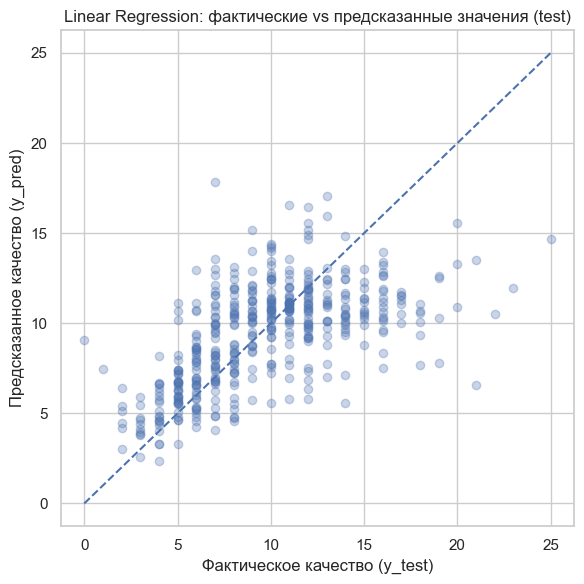

In [147]:
y_test_pred_rf = model.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Фактическое качество (y_test)")
plt.ylabel("Предсказанное качество (y_pred)")
plt.title(f"{linear_regression_name}: фактические vs предсказанные значения (test)")
plt.tight_layout()
plt.show()

Видим, что там там где целевая переменная в обучающей выборке была в меньшем количество, модель сильн ошибается. Так где распредление достаточно равномерно модель в целом работает неплохо (5 - 15)

In [148]:
import seaborn as sns
sns.set(style="whitegrid")

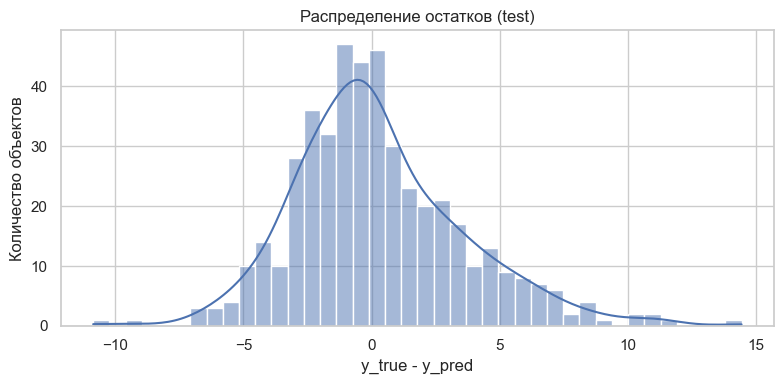

In [149]:
residuals = y_test - y_test_pred_rf

plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Распределение остатков (test)")
plt.xlabel("y_true - y_pred")
plt.ylabel("Количество объектов")
plt.tight_layout()
plt.show()

Остататки распределены не совсем гладко, но горб около нуля, что в целом хорошо. Однако видно, что модель часто занижает результаты там где целевая переменная должна принимать большие значения

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [151]:
linear_regression_MAE_name = "Linear Regression (MAE)"

linear_regression_MAE_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown='ignore', drop='first')),
    ("scaler", StandardScaler(with_mean=False)),
    ("model", SGDRegressor(
    loss='epsilon_insensitive',
    epsilon=0,  # для чистого MAE
    random_state=42,
    max_iter=1000,
    tol=1e-3
    ))
])


In [152]:
model = linear_regression_MAE_pipeline.fit(X_train, y_train)

In [153]:
baseline_name = f"Baseline: {linear_regression_MAE_name}"

# средняя аренда только по train
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_val_pred = model.predict(X_val)

# логируем результаты
log_results(baseline_name, "train", y_train, y_train_pred)
log_results(baseline_name, "val",   y_val,   y_val_pred)
log_results(baseline_name, "test",  y_test,  y_test_pred)

# печатаем метрики
print("Модель:", baseline_name)
print_metrics("Train", y_train, y_train_pred)
print_metrics("Val",   y_val,   y_val_pred)
print_metrics("Test",  y_test,  y_test_pred)

Модель: Baseline: Linear Regression (MAE)
=== Train ===
MSE : 1.53
RMSE: 1.24
MAE : 0.96
R2  : 0.9045

=== Val ===
MSE : 19.72
RMSE: 4.44
MAE : 3.39
R2  : -0.1524

=== Test ===
MSE : 19.08
RMSE: 4.37
MAE : 3.19
R2  : -0.1240



c:\Users\Latonov Valery\Desktop\Мага МЛ\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [1, 2, 3, 4, 5, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
c:\Users\Latonov Valery\Desktop\Мага МЛ\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [1, 2, 4, 5, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


Обратим внимание, что на тесте метрика R2 сильно хуже, не смотря на то, что на Train она дотаточно неплоха, что говорит о переобучении модели

[2.01635928 8.98487121 6.92727127 4.05884697 8.10275985]


c:\Users\Latonov Valery\Desktop\Мага МЛ\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [1, 2, 3, 4, 5, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


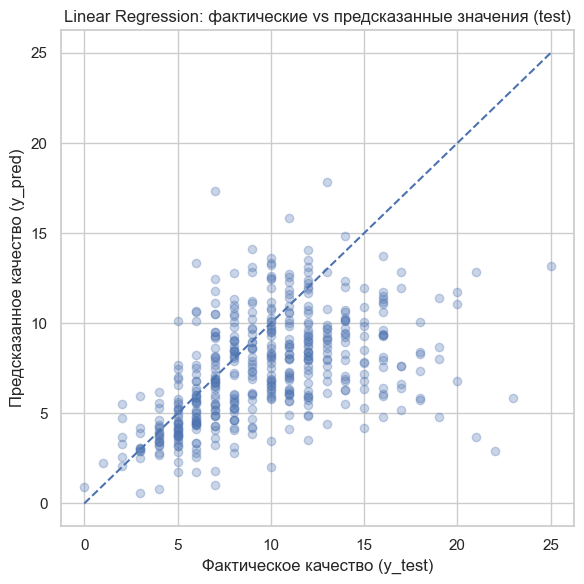

In [154]:
y_test_pred_rf = model.predict(X_test)
print(y_test_pred_rf[:5])
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Фактическое качество (y_test)")
plt.ylabel("Предсказанное качество (y_pred)")
plt.title(f"{linear_regression_name}: фактические vs предсказанные значения (test)")
plt.tight_layout()
plt.show()

Картина не сильно изменилась

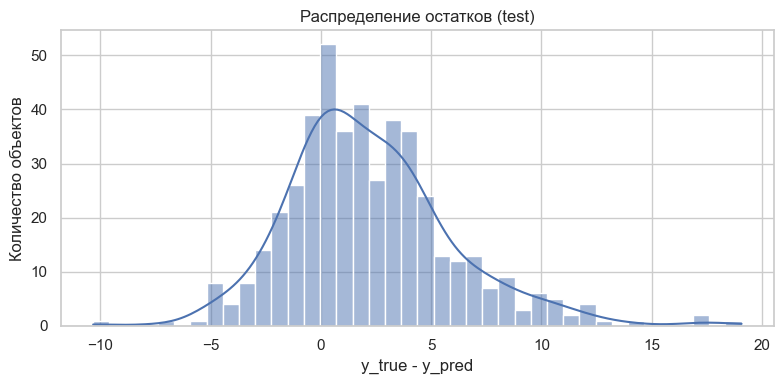

In [155]:
residuals = y_test - y_test_pred_rf

plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Распределение остатков (test)")
plt.xlabel("y_true - y_pred")
plt.ylabel("Количество объектов")
plt.tight_layout()
plt.show()

Видим, что график стал менее гладким и центр горба сместился больше вправо, что говори о том, что модель очень часто занижает оценки

In [156]:
from copy import copy

represent = []

for i in results: 

    for j in results[i]['test']:

        row = copy(results[i]['test'])

        row['baseline'] = i

        represent.append(row)

pd.DataFrame(represent).groupby('baseline').mean()

,mse,rmse,mae,r2
baseline,,,,
Baseline: Linear Regression,11.257102,3.355161,2.507022,0.336731
Baseline: Linear Regression (MAE),19.076064,4.367615,3.190812,-0.123963
Baseline: mean,16.975949,4.120188,3.334339,-0.000224
Baseline: median,17.379386,4.168859,3.326754,-0.023995


# Вывод

При решении данной задачи более хорошо себя показала лосс MSE, при ее использовании метрика R2 показала себя сильно лучше чем при MAE, также распределение остатков при MSE более равномерное 